# Dataset setup:
Download hybrid "datasets" folder
<br>into the current <b><u>"hybrid_model_train"</b></u> directory:
<br><br><b>Manually-annotated datasets: For images annotated manually</b>
<br>./datasets/manually_annotated/raw_images (178 images)
<br>./datasets/manually_annotated/raw_labels (178 labels)
<b><br><br>Auto-annotated datasets: For images annotated with pre-trained model</b>
<br>- Raw Images Datasets: Contains images not annotated
<br>./datasets/raw_images (2746 images)
<br>(note: file names larger than 99 characters may not be read, update manually)

### Import Modules and Libraries

In [2]:
import os # File 
import cv2 # Opencv for images
import sys
import yaml
import glob
import torch
import shutil
import random
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from ultralytics import YOLO # For obeject detection
import albumentations as A # For image augmentation
from albumentations.pytorch import ToTensorV2 # For image formating
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
# Suppress all warnings
import warnings

In [3]:
warnings.filterwarnings("ignore") # Suppress all warnings
# Import msaai from parent folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/")
import msaai 

### Create directories

In [4]:
# Create direcories to organize images and cleanup for to avoid duplicate images 
dataset_base_dir = "datasets/"
# Source directory containing all raw manually annotated images
manual_source_images_dir = os.path.join(dataset_base_dir, "manually_annotated/raw_images")
manual_source_labels_dir = os.path.join(dataset_base_dir, "manually_annotated/raw_labels")
# Source directory containing all raw unannotated images 
raw_images_dir = os.path.join(dataset_base_dir, "raw_images")

# Create auto-annotated directories
auto_annotated_images_dir = os.path.join(dataset_base_dir, "auto_annotated/images")
auto_annotated_labels_dir = os.path.join(dataset_base_dir, "auto_annotated/labels")
# Create manually annotated directories
manual_train_images_dir = os.path.join(dataset_base_dir, "manually_annotated/images/train")
manual_train_labels_dir = os.path.join(dataset_base_dir, "manually_annotated/labels/train")
manual_val_images_dir = os.path.join(dataset_base_dir, "manually_annotated/images/val")
manual_val_labels_dir = os.path.join(dataset_base_dir, "manually_annotated/labels/val")

### Reset directories

In [4]:

# Define directories to reset
directories_to_reset = [
    auto_annotated_images_dir,
    auto_annotated_labels_dir,

    # manually annotated directories
    manual_train_images_dir,
    manual_train_labels_dir,
    manual_val_images_dir,
    manual_val_labels_dir 
]
# Reset directories
msaai.reset_directories(directories_to_reset)

print("Directories reset and ready for use.")

Deleted existing directory: datasets/auto_annotated/images
Recreated directory: datasets/auto_annotated/images
Deleted existing directory: datasets/auto_annotated/labels
Recreated directory: datasets/auto_annotated/labels
Deleted existing directory: datasets/manually_annotated/images/train
Recreated directory: datasets/manually_annotated/images/train
Deleted existing directory: datasets/manually_annotated/labels/train
Recreated directory: datasets/manually_annotated/labels/train
Deleted existing directory: datasets/manually_annotated/images/val
Recreated directory: datasets/manually_annotated/images/val
Deleted existing directory: datasets/manually_annotated/labels/val
Recreated directory: datasets/manually_annotated/labels/val
Directories reset and ready for use.


### Create manual_data.yaml

In [5]:
# create manual_data.yaml in local datasets folder
ppe_classes = [
    'Hardhat',
    'Mask',
    'NO-Hardhat',
    'NO-Mask',
    'NO-Safety Vest',
    'Person',
    'Safety Cone',
    'Safety Vest',
    'Machinery',
    'Vehicle'
]
number_classes = len(ppe_classes)
output_dir = 'datasets'

dict_file = {
    'train': 'manually_annotated/images/train',
    'val': 'manually_annotated/images/val',
    'nc': number_classes,
    'names': ppe_classes
}

with open(os.path.join(dataset_base_dir, 'manual_data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)
# Full yaml path to prevent path error
manual_yaml_path = str(Path('datasets/manual_data.yaml').resolve())

### Create final_hybrid_data.yaml

In [6]:
# create final yaml in datasets 
dict_file = {
    'train': 'images/train', 
    'val': 'images/val',
    'test': 'images/test', 
    'nc': number_classes,
    'names': ppe_classes
}

with open(os.path.join(dataset_base_dir, 'final_hybrid_data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)
# Full yaml path to prevent path error
final_yaml_path = str(Path('datasets/final_hybrid_data.yaml').resolve())

### Random Image Visualization

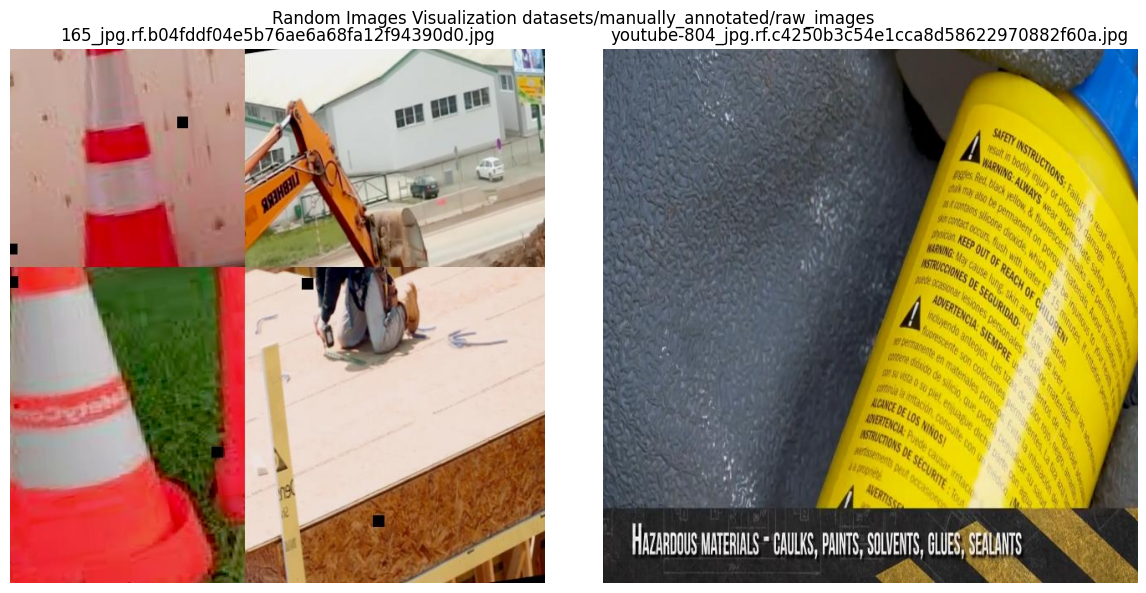

In [7]:

msaai.visualize_random_imgs(manual_source_images_dir, num_images=2)

### Custom images dataset

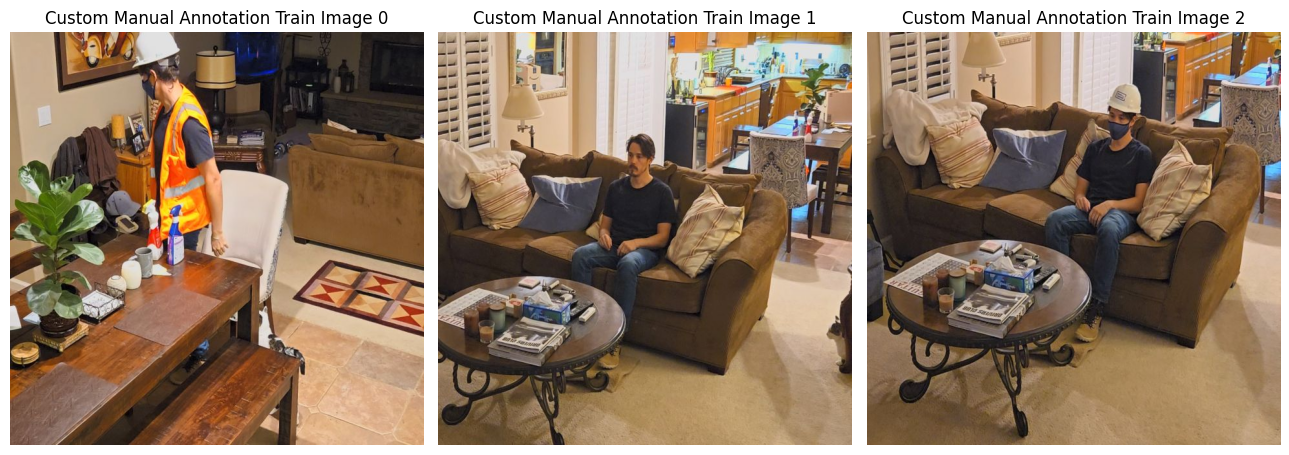

In [8]:
# Get the paths to the first three custom images
image_paths = glob.glob(f"{manual_source_images_dir}/scene*.jpg")[:3]

msaai.visualize_image_list(image_paths, title='Custom Manual Annotation Train Image')


### Google images dataset

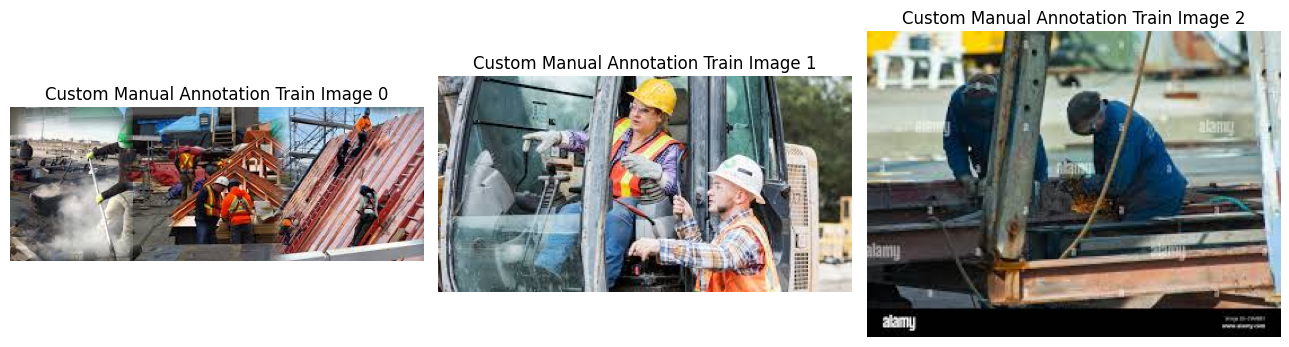

In [9]:
# Get the paths to the first three custom images
image_paths = glob.glob(f"{raw_images_dir}/images*.jpeg")[:3]

msaai.visualize_image_list(image_paths, title='Custom Manual Annotation Train Image')

### Image Properties

In [9]:
# NO NEED Define function to analyze image dimensions, aspect ratio
def analyze_image_properties(images_dir):
    properties = {"filename": [], "width": [], "height": [], "aspect_ratio": []}

    for image_file in os.listdir(images_dir):
        if image_file.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(images_dir, image_file)
            image = cv2.imread(image_path)
            height, width = image.shape[:2]
            aspect_ratio = width / height
            properties["filename"].append(image_file)
            properties["width"].append(width)
            properties["height"].append(height)
            properties["aspect_ratio"].append(aspect_ratio)

    # Convert to pandas DataFrame for analysis
    df = pd.DataFrame(properties)
    return df
print("Image Properties Analysis Of Manually Labeled Images")
analyze_image_properties(manual_source_images_dir)

Image Properties Analysis Of Manually Labeled Images


filename  width  height  \
0        2_jpg.rf.b6161c4d7722be0e92af7b88e8391da5.jpg    640     640   
1                                     scene3_all_4.jpg    640     640   
2                                    scene1_none_4.jpg    640     640   
3    4c43875bc97cdaece84ac6ce555235f1_jpg.rf.8bffc5...    640     640   
4    youtube-446_jpg.rf.b9d9b80538b79252761946ece0b...    640     640   
..                                                 ...    ...     ...   
173  -1975-_png_jpg.rf.d6c068e0d3eebc3b8e002413529c...    640     640   
174      2_jpg.rf.2a2cafa3fd6db594c2f3a46f971b1c14.jpg    640     640   
175                                  scene2_mask_1.jpg    640     640   
176    165_jpg.rf.8e28e2ec55d7ab727f8a5cd072024dd2.jpg    640     640   
177  youtube-470_jpg.rf.6aebf4cfb6c5a7e703c6532ca50...    640     640   

     aspect_ratio  
0             1.0  
1             1.0  
2             1.0  
3             1.0  
4             1.0  
..            ...  
173           1.0  
174           1.0  
175           1.0  
176           1.0  
177           1.0  

[178 rows x 4 columns]

### Split manually annotated datasets to train and val

In [10]:
# Define function to split manually annotated dataset into train and valation sets
def split_manual_dataset(images_dir, labels_dir, split_ratio=0.8):
    image_files = [
        f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    random.shuffle(image_files)

    train_size = int(split_ratio * len(image_files))
    train_files = image_files[:train_size]
    val_files = image_files[train_size:]

    # Copy train files and corresponding labels
    for file in train_files:
        label_file = os.path.splitext(file)[0] + ".txt"  # Match label with image file
        image_src = os.path.join(images_dir, file)
        label_src = os.path.join(labels_dir, label_file)
        shutil.copy(image_src, os.path.join(manual_train_images_dir, file))
        shutil.copy(label_src, os.path.join(manual_train_labels_dir, label_file))

    # Copy val files and corresponding labels
    for file in val_files:
        label_file = os.path.splitext(file)[0] + ".txt"  # Match label with image file
        image_src = os.path.join(images_dir, file)
        label_src = os.path.join(labels_dir, label_file)
        shutil.copy(image_src, os.path.join(manual_val_images_dir, file))
        shutil.copy(label_src, os.path.join(manual_val_labels_dir, label_file))

    print("Manual dataset split completed. Images and labels copied to train and val directories.")

split_manual_dataset(manual_source_images_dir, manual_source_labels_dir)

Manual dataset split completed. Images and labels copied to train and val directories.


## USE MPS on MAC 
Run only on macos

In [11]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")


### <b><u>Train base model</b></u> with manually annotated datasets

In [12]:
# Train the generic model on manually labeled data
def train_model(manual_train_images, manual_val_images, epochs=50):

    # Train the model
    print("Training model on manually labeled dataset...")
    model = YOLO("../../models/yolov8m.pt")
    model.train(
        data=manual_yaml_path,
        epochs=50, # Iterations
        device='mps',
        imgsz=640, # Image size
        batch=-1, # Batch size
        seed=88, # Train Repeatability
        optimizer="auto", # Automatic speed, stability optimization
        patience=10 # Num of epochs to discontinue unimproved train
    )
    print("Model training completed.")
    return model

# Train the model on the manual dataset
trained_model = train_model(manual_train_images_dir, manual_val_images_dir)

Training model on manually labeled dataset...
New https://pypi.org/project/ultralytics/8.3.49 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.12.4 torch-2.5.1 MPS (Apple M1 Pro)
engine/trainer: task=detect, mode=train, model=../../models/yolov8m.pt, data=/Users/victorhugogermano/Development/aai-501-final-project/notebooks/hybrid_model_train/datasets/manual_data.yaml, epochs=50, time=None, patience=10, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer

train: Scanning /Users/victorhugogermano/Development/aai-501-final-project/notebooks/hybrid_model_train/datasets/manually_annotated/labels/tra

train: New cache created: /Users/victorhugogermano/Development/aai-501-final-project/notebooks/hybrid_model_train/datasets/manually_annotated/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch:  ⚠️ intended for CUDA devices, using default batch-size 16



train: Scanning /Users/victorhugogermano/Development/aai-501-final-project/notebooks/hybrid_model_train/datasets/manually_annotated/labels/tra

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /Users/victorhugogermano/Development/aai-501-final-project/notebooks/hybrid_model_train/datasets/manually_annotated/labels/val..

val: New cache created: /Users/victorhugogermano/Development/aai-501-final-project/notebooks/hybrid_model_train/datasets/manually_annotated/labels/val.cache
Plotting labels to ../train/runs/detect/train2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to ../train/runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      14.5G        nan        nan        nan        160        640: 100%|██████████| 9/9 [08:48<00:00, 58.76s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.89s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      14.8G        nan        nan        nan        284        640: 100%|██████████| 9/9 [01:21<00:00,  9.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.03s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      14.5G        nan        nan        nan        192        640: 100%|██████████| 9/9 [02:35<00:00, 17.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.09s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      14.9G        nan        nan        nan        198        640: 100%|██████████| 9/9 [01:50<00:00, 12.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.26s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      15.6G        nan        nan        nan        210        640: 100%|██████████| 9/9 [02:03<00:00, 13.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.08s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      15.7G        nan        nan        nan        203        640: 100%|██████████| 9/9 [01:27<00:00,  9.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.85s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      15.7G        nan        nan        nan        183        640: 100%|██████████| 9/9 [01:27<00:00,  9.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.81s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      14.6G        nan        nan        nan        216        640: 100%|██████████| 9/9 [01:16<00:00,  8.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.84s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      14.6G        nan        nan        nan        221        640: 100%|██████████| 9/9 [01:08<00:00,  7.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.91s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      15.1G        nan        nan        nan        328        640: 100%|██████████| 9/9 [01:10<00:00,  7.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.85s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      13.9G        nan        nan        nan        164        640: 100%|██████████| 9/9 [01:13<00:00,  8.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.91s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      14.7G        nan        nan        nan        137        640: 100%|██████████| 9/9 [02:04<00:00, 13.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.72s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      14.7G        nan        nan        nan        226        640: 100%|██████████| 9/9 [01:40<00:00, 11.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.39s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      14.9G        nan        nan        nan        253        640: 100%|██████████| 9/9 [01:39<00:00, 11.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.05s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      14.8G        nan        nan        nan        215        640: 100%|██████████| 9/9 [01:54<00:00, 12.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.07s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      14.8G        nan        nan        nan        224        640: 100%|██████████| 9/9 [01:36<00:00, 10.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.33s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      14.8G        nan        nan        nan        176        640: 100%|██████████| 9/9 [01:56<00:00, 12.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.76s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50        15G        nan        nan        nan        263        640: 100%|██████████| 9/9 [01:36<00:00, 10.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.27s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      14.1G        nan        nan        nan        226        640: 100%|██████████| 9/9 [01:09<00:00,  7.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.97s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      14.9G        nan        nan        nan        257        640: 100%|██████████| 9/9 [01:13<00:00,  8.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50        15G        nan        nan        nan        198        640: 100%|██████████| 9/9 [01:25<00:00,  9.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      15.3G        nan        nan        nan        229        640: 100%|██████████| 9/9 [01:21<00:00,  9.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      15.1G        nan        nan        nan        340        640: 100%|██████████| 9/9 [01:19<00:00,  8.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.19s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50        15G        nan        nan        nan        200        640: 100%|██████████| 9/9 [01:20<00:00,  8.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50        15G        nan        nan        nan        228        640: 100%|██████████| 9/9 [01:23<00:00,  9.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      15.4G        nan        nan        nan        220        640: 100%|██████████| 9/9 [01:26<00:00,  9.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      15.1G        nan        nan        nan        227        640: 100%|██████████| 9/9 [01:21<00:00,  9.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.29s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50        15G        nan        nan        nan        238        640: 100%|██████████| 9/9 [01:32<00:00, 10.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      15.4G        nan        nan        nan        242        640: 100%|██████████| 9/9 [01:16<00:00,  8.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      15.3G        nan        nan        nan        291        640: 100%|██████████| 9/9 [01:03<00:00,  7.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.89s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      15.1G        nan        nan        nan        130        640: 100%|██████████| 9/9 [01:40<00:00, 11.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      15.1G        nan        nan        nan        194        640: 100%|██████████| 9/9 [01:26<00:00,  9.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      15.2G        nan        nan        nan        228        640: 100%|██████████| 9/9 [01:34<00:00, 10.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.78s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      15.3G        nan        nan        nan        279        640: 100%|██████████| 9/9 [01:21<00:00,  9.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      14.1G        nan        nan        nan        250        640: 100%|██████████| 9/9 [01:27<00:00,  9.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.25s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      15.2G        nan        nan        nan        227        640: 100%|██████████| 9/9 [01:37<00:00, 10.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.68s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      15.3G        nan        nan        nan        260        640: 100%|██████████| 9/9 [01:27<00:00,  9.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.85s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      15.3G        nan        nan        nan        197        640: 100%|██████████| 9/9 [01:35<00:00, 10.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.29s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      15.3G        nan        nan        nan        198        640: 100%|██████████| 9/9 [02:27<00:00, 16.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  3.00s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      14.2G        nan        nan        nan        317        640: 100%|██████████| 9/9 [01:50<00:00, 12.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.25s/it]

                   all         36        397          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      15.3G        nan        nan        nan        104        640: 100%|██████████| 9/9 [01:50<00:00, 12.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      15.3G        nan        nan        nan        131        640: 100%|██████████| 9/9 [02:16<00:00, 15.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.03s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      14.3G        nan        nan        nan        104        640: 100%|██████████| 9/9 [01:54<00:00, 12.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.19s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      15.4G        nan        nan        nan        112        640: 100%|██████████| 9/9 [02:02<00:00, 13.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.55s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      15.5G        nan        nan        nan         95        640: 100%|██████████| 9/9 [01:25<00:00,  9.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      15.8G        nan        nan        nan        116        640: 100%|██████████| 9/9 [01:24<00:00,  9.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.81s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      14.4G        nan        nan        nan        125        640: 100%|██████████| 9/9 [01:32<00:00, 10.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      15.5G        nan        nan        nan        112        640: 100%|██████████| 9/9 [01:18<00:00,  8.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.83s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      15.5G        nan        nan        nan        130        640: 100%|██████████| 9/9 [01:44<00:00, 11.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]

                   all         36        397          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      15.5G        nan        nan        nan        186        640: 100%|██████████| 9/9 [01:38<00:00, 10.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.04s/it]

                   all         36        397          0          0          0          0



50 epochs completed in 1.535 hours.
Optimizer stripped from ../train/runs/detect/train2/weights/last.pt, 52.0MB
Optimizer stripped from ../train/runs/detect/train2/weights/best.pt, 52.0MB

Validating ../train/runs/detect/train2/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.12.4 torch-2.5.1 MPS (Apple M1 Pro)
Model summary (fused): 218 layers, 25,845,550 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]

                   all         36        397          0          0          0          0


Speed: 1.7ms preprocess, 96.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to ../train/runs/detect/train2
Model training completed.


### Automatically annotate datasets with base model

In [13]:
# load the pre-trained model to auto annotated the raw_images
model_path = "runs/detect/train/weights/best.pt"  # Path to your trained YOLO model
def auto_annotate_images(model_path, raw_images_dir, output_images_dir, output_labels_dir, confidence_threshold=0.5):
    
    """
    Automatically annotate images using a pre-trained YOLO model.

    Args:
    - model_path (str): Path to the trained YOLO model.
    - raw_images_dir (str): Path to the directory containing raw images.
    - output_images_dir (str): Path to save annotated images.
    - output_labels_dir (str): Path to save annotation labels in YOLO format.
    - confidence_threshold (float): Minimum confidence score to include a detection.
    """
    total_images = len([image_file for image_file in os.listdir(raw_images_dir) if image_file.lower().endswith(('.jpg', '.jpeg', '.png'))])
    # load the pre-trained model
    model = YOLO(model_path)

    # Create output directories if they don't exist
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)
        
    for i, image_file in enumerate(os.listdir(raw_images_dir)):
        if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(raw_images_dir, image_file)
            results = model(image_path, verbose=False)  # Perform inference, silence output for each image

            # Save the original image to the output directory
            output_image_path = os.path.join(output_images_dir, image_file)
            cv2.imwrite(output_image_path, cv2.imread(image_path))

            # Prepare the YOLO format label file
            label_file = os.path.splitext(image_file)[0] + ".txt"
            output_label_path = os.path.join(output_labels_dir, label_file)

            with open(output_label_path, "w") as f:
                for result in results[0].boxes:
                    box = result.xywhn[0].cpu().numpy()  # Normalized x_center, y_center, width, height
                    class_id = int(result.cls[0].cpu().numpy())
                    confidence = float(result.conf[0].cpu().numpy())

                    # Filter by confidence threshold
                    if confidence >= confidence_threshold:
                        f.write(f"{class_id} {box[0]:.3f} {box[1]:.3f} {box[2]:.3f} {box[3]:.3f}\n")

            # Print the current progress (overwrite previous line)
            print(f"Annotating image {i+1} of {total_images}...", end='\r')
    
    print(f"Auto-annotation completed.\n' Annotated images and labels saved in {output_images_dir} and {output_labels_dir}.")
        
auto_annotate_images(model_path, raw_images_dir, auto_annotated_images_dir, auto_annotated_labels_dir)

Auto-annotation completed.746...
' Annotated images and labels saved in datasets/auto_annotated/images and datasets/auto_annotated/labels.


### Combine manual and auto annotated datasets

In [15]:
# Function to combine datasets (manual + auto-annotated)
# combined directory path

combined_images_dir = os.path.join(dataset_base_dir, "images")
combined_labels_dir = os.path.join(dataset_base_dir, "labels")

# check if path exist otherwise create it
os.makedirs(combined_images_dir, exist_ok=True)
os.makedirs(combined_labels_dir, exist_ok=True)


def copy_files(src_images_dir, src_labels_dir):
    for file in os.listdir(src_images_dir):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            # Copy image file
            src_image_path = os.path.join(src_images_dir, file)
            dest_image_path = os.path.join(combined_images_dir, file)
            shutil.copy(src_image_path, dest_image_path)

            # Copy corresponding label file
            label_file = os.path.splitext(file)[0] + ".txt"
            src_label_path = os.path.join(src_labels_dir, label_file)
            dest_label_path = os.path.join(combined_labels_dir, label_file)
            shutil.copy(src_label_path, dest_label_path)
            
# copy manually annotated images data
print("Copying manually annotated training data...")
copy_files(manual_train_images_dir, manual_train_labels_dir)

# copy manually annotated validation data
print("Copying manually annotated validation data...")
copy_files(manual_val_images_dir, manual_val_labels_dir)

# Copy auto-annotated data
print("Copying auto-annotated data...")
copy_files(auto_annotated_images_dir, auto_annotated_labels_dir)

print("Dataset combination completed.")
print(f"Combined images stored in: {combined_images_dir}")
print(f"Combined labels stored in: {combined_labels_dir}")

Copying manually annotated training data...
Copying manually annotated validation data...
Copying auto-annotated data...
Dataset combination completed.
Combined images stored in: datasets/images
Combined labels stored in: datasets/labels


### Split combined images and labels to train, test and val

In [16]:
# extract the combined image files for random split
# split directory for detection
train_images_dir = os.path.join(dataset_base_dir, "images/train")
train_labels_dir = os.path.join(dataset_base_dir, "labels/train")

test_images_dir = os.path.join(dataset_base_dir, "images/test")
test_labels_dir = os.path.join(dataset_base_dir, "labels/test")

val_images_dir = os.path.join(dataset_base_dir, "images/val")
val_labels_dir = os.path.join(dataset_base_dir, "labels/val")

# create dataset directories for detection & prediction
for dir_path in [
    train_images_dir,
    train_labels_dir,
    test_images_dir,
    test_labels_dir,
    val_images_dir,
    val_labels_dir
]:
    os.makedirs(dir_path, exist_ok=True)

image_files = [f for f in os.listdir(combined_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(image_files)

# Create DataFrame with file paths and dataset split assignments
df = pd.DataFrame({"filename": image_files})
# dynamically split dataset into train, valid, and test
# split sizes
train_size = int(0.7 * len(df))  # 70% for training
val_size = int(0.2 * len(df))  # 20% for validation
test_size = len(df) - train_size - val_size  # remaining 10% for testing

# split labels
train_labels = ["train"] * train_size
val_labels = ["val"] * val_size
test_labels = ["test"] * test_size

# combine and assign to DataFrame
df["split"] = train_labels + val_labels + test_labels

# Function to move files into corresponding split directories
def move_files(df, src_images_dir, src_labels_dir, dest_images_dir, dest_labels_dir):
    for _, row in df.iterrows():  # iterate over a DataFrame row by row
        filename = row["filename"]
        split = row["split"]
        image_path = os.path.join(src_images_dir, filename)
        label_path = os.path.join(src_labels_dir, os.path.splitext(filename)[0] + ".txt")

        dest_image_dir = dest_images_dir[split]
        dest_label_dir = dest_labels_dir[split]

        # move image
        shutil.move(image_path, os.path.join(dest_image_dir, filename))

        # move label 
        shutil.move(label_path, os.path.join(dest_label_dir, os.path.splitext(filename)[0] + ".txt"))
        

# map split directories for images and labels
dest_images_dir = {"train": train_images_dir, "val": val_images_dir, "test": test_images_dir}
dest_labels_dir = {"train": train_labels_dir, "val": val_labels_dir, "test": test_labels_dir}

# call move fuxn
move_files(df, combined_images_dir, combined_labels_dir, dest_images_dir, dest_labels_dir)

print("Dataset split completed.")
print(f"Training images: {len(os.listdir(train_images_dir))}, Labels: {len(os.listdir(train_labels_dir))}")
print(f"Validation images: {len(os.listdir(val_images_dir))}, Labels: {len(os.listdir(val_labels_dir))}")
print(f"Testing images: {len(os.listdir(test_images_dir))}, Labels: {len(os.listdir(test_labels_dir))}")

Dataset split completed.
Training images: 2842, Labels: 2842
Validation images: 1680, Labels: 1680
Testing images: 960, Labels: 960


### <b><u>Train the final model </b></u>with the combined datasets
#### (NOTE: update model_path for the base model created)

In [6]:
input_name = input('Please enter run folder description:')
# load pre-trained YOLO base model
model_path = "runs/detect/train/weights/best.pt"
model = YOLO(model_path)
# Train the model
print("Training the final model...")
model.train(
    data=final_yaml_path,
    device='mps',
    epochs=30, # Iterations
    imgsz=640, # Image size
    batch=-1, # Batch size
    patience=10, # Num of epochs to discontinue unimproved train
    amp=True, # Reduce memore, increase speed
    plots = True, # produce plots
    name = input_name, # Run folder name
)
print("Model training completed.")

Please enter run folder description: final


Training the final model...


NameError: name 'final_yaml_path' is not defined

### Evalutate train results

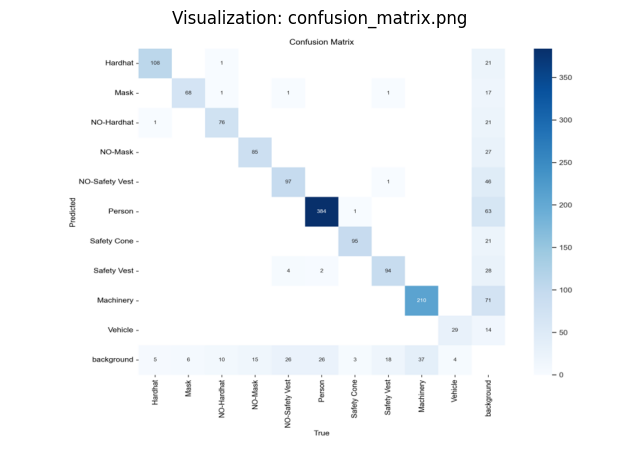

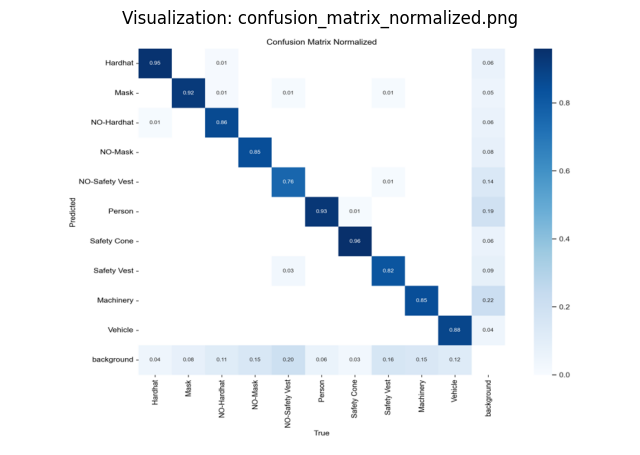

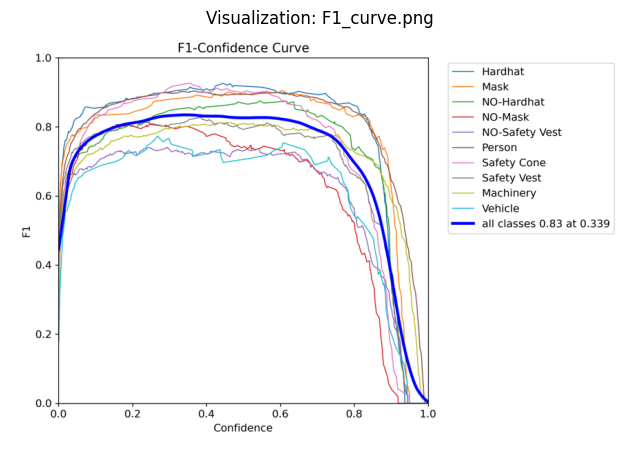

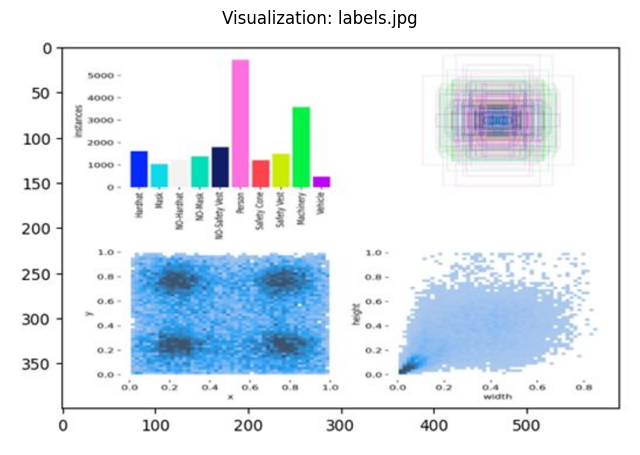

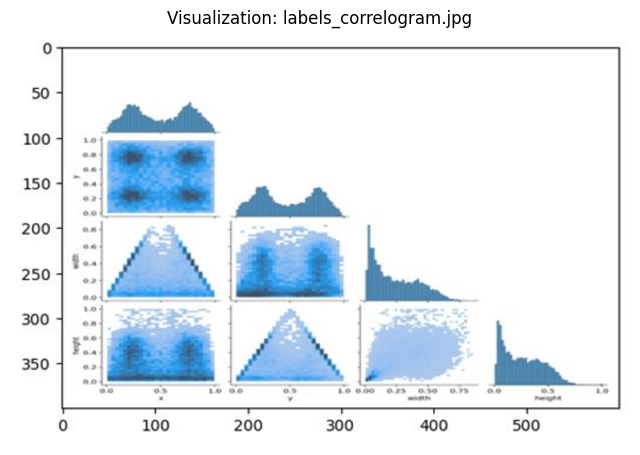

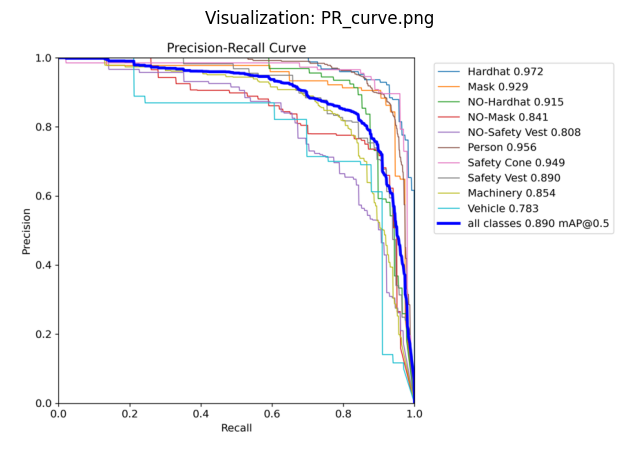

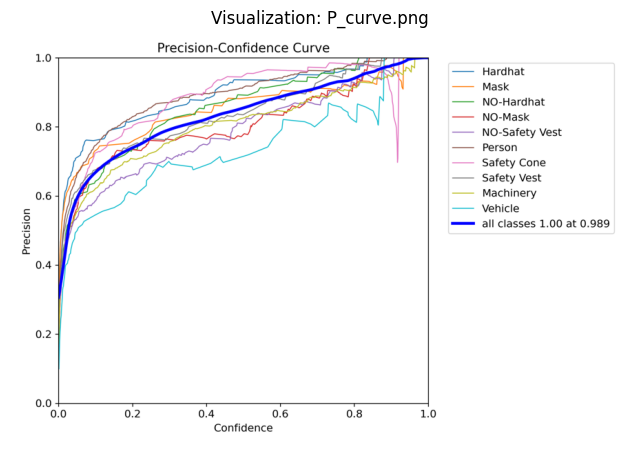

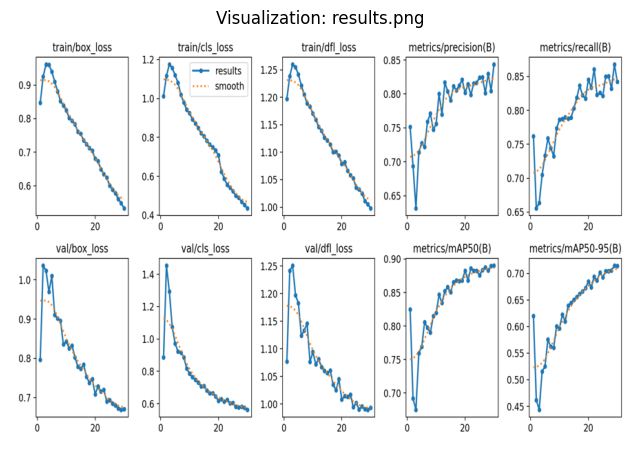

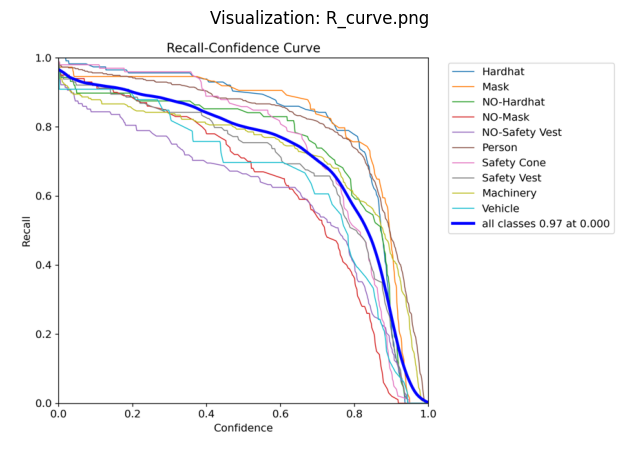

In [52]:
run_path = "runs/detect/train4"
# loop through images, do not include images for val and train
img_files = [
    f for f in os.listdir(run_path) 
    if f.endswith((".png", ".jpg")) and not f.startswith(("train", "val"))
]

# Loop through each image file and display it
for img_file in img_files:
    file_path = os.path.join(run_path, img_file)
    image = Image.open(file_path).resize((900, 600)) # Width, height
    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")  # Hide axes
    plt.title(f"Visualization: {img_file}")
    plt.show()

### Visualize prediction on test sets


image 1/1 C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\images\test\youtube-497_jpg.rf.e0f0250ef7939eb4813e9b2f57b1a5ff.jpg: 640x640 1 Mask, 1 NO-Hardhat, 2 NO-Safety Vests, 2 Persons, 2 Machinerys, 267.9ms
Speed: 2.0ms preprocess, 267.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


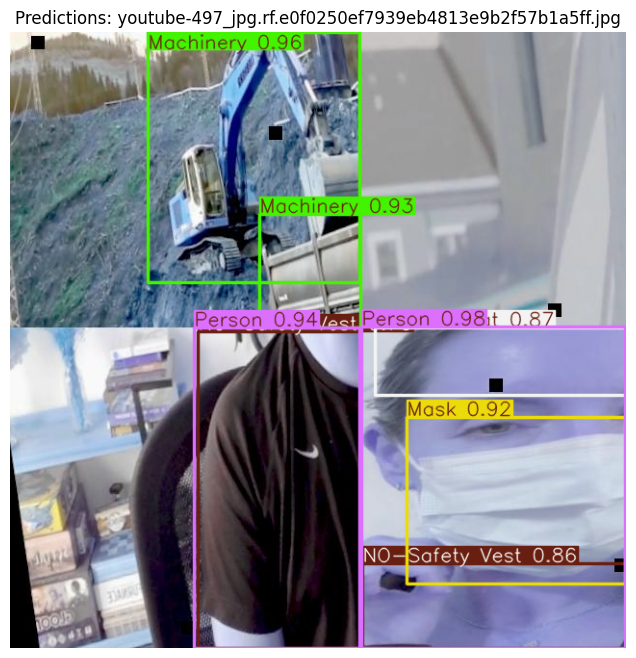


image 1/1 C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\images\test\IMG_3103_mp4-15_jpg.rf.d7e8a84fc7e9d53fe348320ea3af0e94.jpg: 640x640 2 Hardhats, 1 Mask, 2 NO-Hardhats, 3 NO-Masks, 1 NO-Safety Vest, 6 Persons, 1 Safety Cone, 1 Machinery, 253.6ms
Speed: 2.0ms preprocess, 253.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


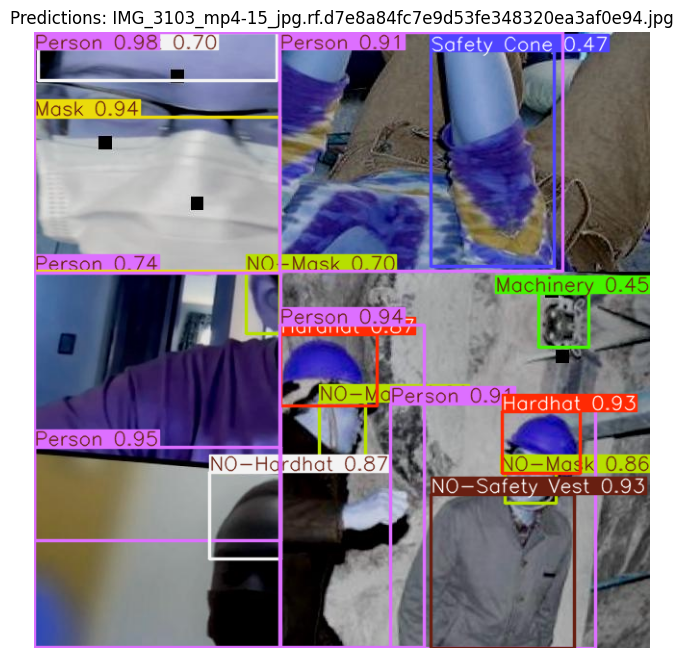


image 1/1 C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\images\test\01261_jpg.rf.ee044d42291843f1358960c4d8c1d466.jpg: 640x640 4 Hardhats, 4 NO-Masks, 1 NO-Safety Vest, 4 Persons, 4 Safety Vests, 1 Vehicle, 235.2ms
Speed: 2.0ms preprocess, 235.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


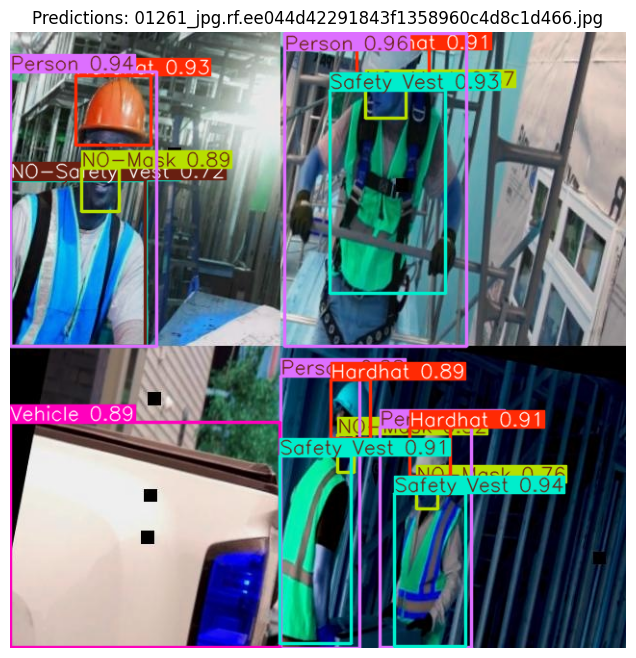

In [54]:
# load the final trained model
model = YOLO("runs/detect/train4/weights/best.pt")

# Path to test images
test_images_dir = "datasets/images/test"

# get list of test images
test_images = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# run inference and display predictions
# shuffle the images randomly
random.shuffle(test_images)

# limit to a subset 
test_images_subset = test_images[:3]

# Run inference and display predictions for random images
for test_image in test_images_subset:
    image_path = os.path.join(test_images_dir, test_image)
    results = model.predict(source=image_path, save=False)  # Run inference

    # Display the image with predictions
    img = results[0].plot()  # YOLOv8's built-in method to plot predictions
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predictions: {test_image}")
    plt.show()

### Predict custom images

Results saved to runs\detect\predict


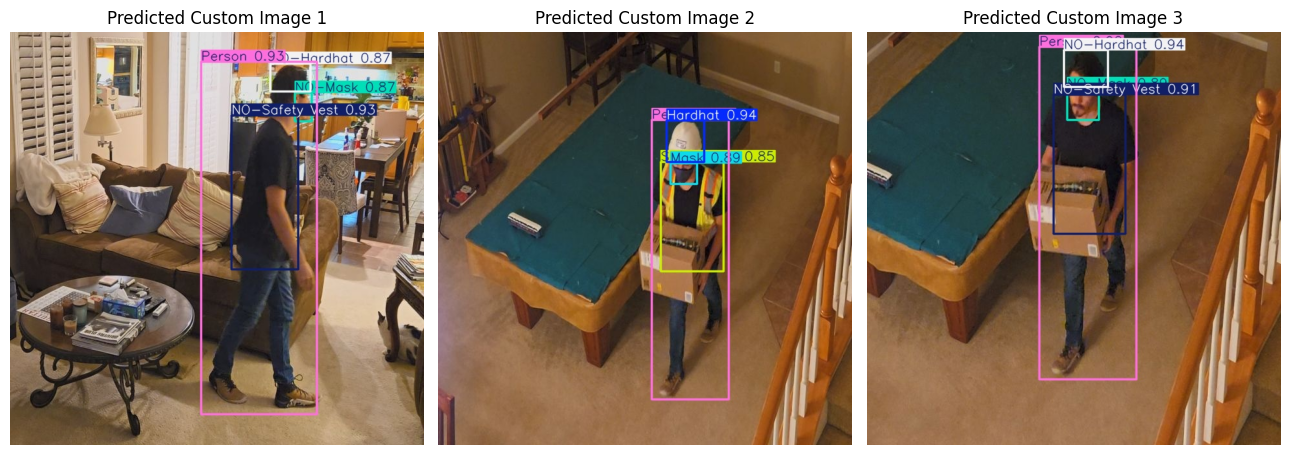

In [11]:
# Remove previous predictions
detect_path = "runs/detect/"
for folder in os.listdir(detect_path):
    folder_path = os.path.join(detect_path, folder)
    if os.path.isdir(folder_path) and folder.startswith("predict"):
        shutil.rmtree(folder_path, ignore_errors=True)

# Make predictions on "scene" images
model.predict(
    f"{test_images_dir}/scene*.jpg",
    save=True,
    conf=0.45,
    agnostic_nms=True,
    iou=0.8,
    verbose=False
)

# Visualize the first three predicted "scene" images
scene_predicted_paths = glob.glob("runs/detect/predict/scene*.jpg")[:3]

if len(scene_predicted_paths) < 3:
    print("Not enough predictions found!")
else:
    fig, axes = plt.subplots(1, 3, figsize=(13, 6))  # 1 row, 3 columns
    for i, ax in enumerate(axes):
        image = mpimg.imread(scene_predicted_paths[i])
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"Predicted Custom Image {i + 1}")
    plt.tight_layout()
    plt.show()